In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fast = 10
mid = 20
slow = 30

This time we're starting with three SMAs.

In [3]:
def create_strat_data(yf_data, fast, mid, slow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['FastSMA'] = data['Close'].rolling(window=fast).mean()
    data['MidSMA'] = data['Close'].rolling(window=mid).mean()
    data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

    data['Strategy'] = 0 

    long  = (data['FastSMA'] > data['MidSMA']) & (data['MidSMA'] > data['SlowSMA'])
    short = (data['FastSMA'] < data['MidSMA']) & (data['MidSMA'] < data['SlowSMA'])
    
    data.loc[long,  'Strategy'] = 1
    data.loc[short, 'Strategy'] = 0

    data['Strategy'] = data['Strategy'].shift(1)

    # s = data['Strategy'] # Forward filling on long positions
    # data['Strategy'] = (
    #     s.where(s != 0)
    #      .mask(s == -1, -1)
    #      .ffill()
    #      .fillna(0)
    #      .shift(1)
    # )   
    
    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

Here I've created conditions for going long and short. For a long position all faster SMAs must be above all slower SMAs. The inverse should be true for short positions.

Edit: For now I've disabled short positions as after some experiemntation they almost never create a positive impact. I think this is because drawdowns are often quite short and over the past 10 years SPY generally trends upwards creating a sort of bias. For another iteration I might try having different lengths for signaling long positions and short positions. I beleive that shorter length for short SMA indicators will work a little better as they won't lag so much. 

In [4]:
yf_ticker_data = yf.download('SPY', period='10y', interval='1d') 
data = create_strat_data(yf_ticker_data, fast, mid, slow)

[*********************100%***********************]  1 of 1 completed


In [5]:
plot_data = data.dropna()
plot_data

Price,Close,High,Low,Open,Volume,FastSMA,MidSMA,SlowSMA,Strategy,Strategy_Returns,Asset_Returns
Date,,,,,,,,,,,
2016-02-23,162.998611,164.693688,162.879944,164.422470,111455300,160.527174,160.832290,160.698376,0.0,0.000000,0.001093
2016-02-24,163.744400,164.024089,160.455960,161.566233,150812200,161.185707,160.959416,160.729170,0.0,0.000000,0.005674
2016-02-25,165.727615,165.736099,163.430794,164.193573,110728300,162.056123,161.273426,160.782281,1.0,0.012112,0.017854
2016-02-26,165.346268,166.693851,165.185233,166.600634,129833700,163.092659,161.526840,160.959133,1.0,0.009783,0.015512
2016-02-29,164.049545,166.312471,163.854615,165.363233,125918100,163.680003,161.520061,161.005183,1.0,0.001864,0.007548
...,...,...,...,...,...,...,...,...,...,...,...
2026-01-05,687.719971,689.429993,686.380005,686.539978,71927200,686.173999,682.999088,679.618650,1.0,1.079085,3.223790
2026-01-06,691.809998,692.320007,687.780029,687.929993,69273800,687.295996,683.406097,680.992065,1.0,1.091450,3.248910
2026-01-07,689.580017,693.960022,689.320007,692.190002,75588300,687.770996,683.804303,682.075120,1.0,1.084708,3.235214


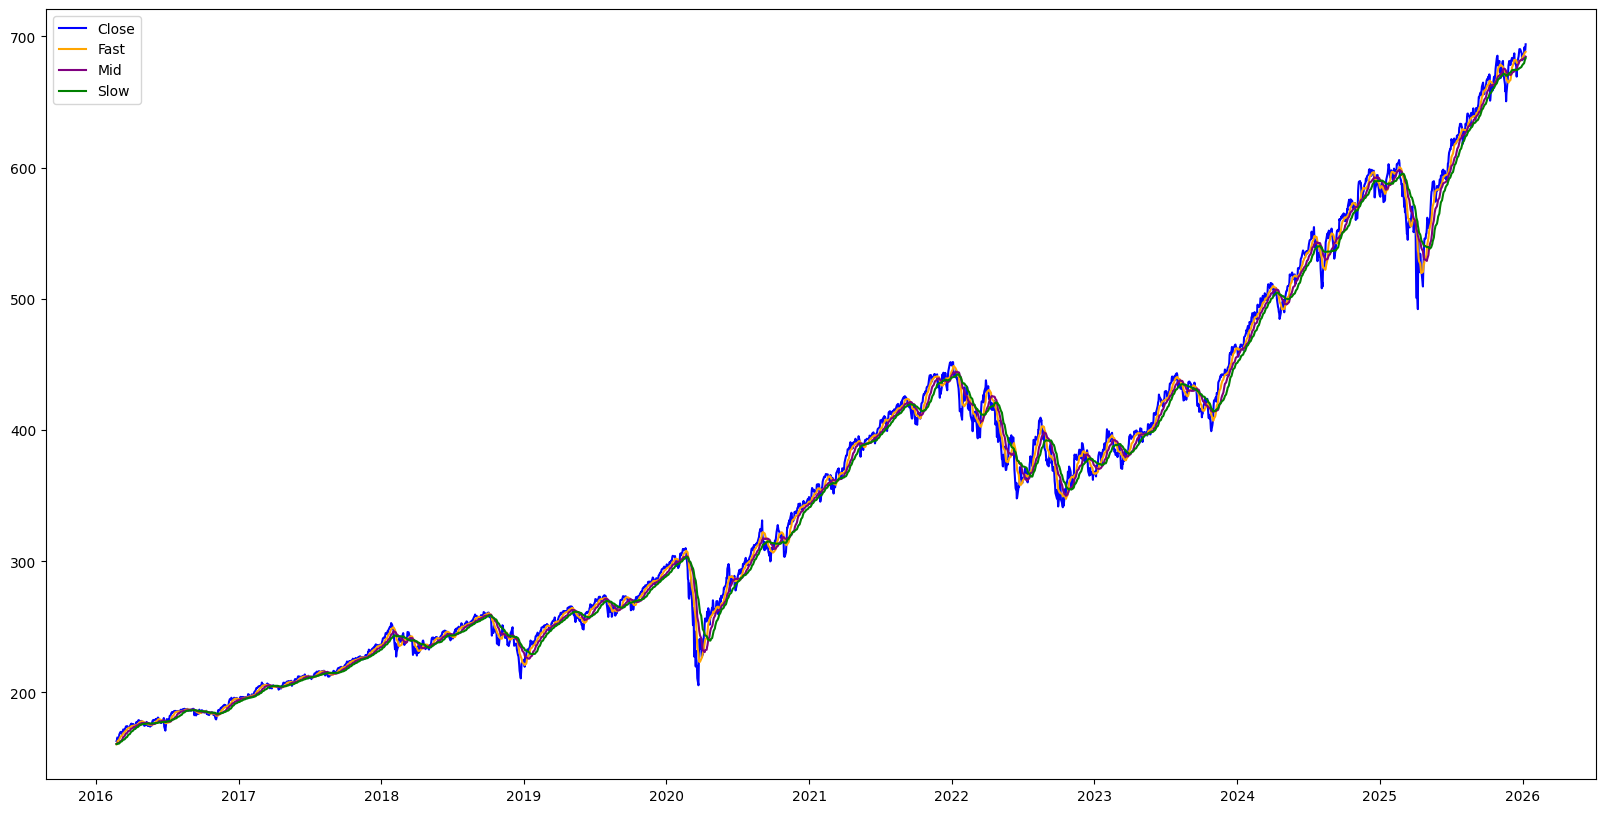

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Close'], color='blue', label='Close')
ax.plot(plot_data['FastSMA'], color='orange', label='Fast')
ax.plot(plot_data['MidSMA'], color='purple', label='Mid')
ax.plot(plot_data['SlowSMA'], color='green', label='Slow')
ax.legend()
plt.show()

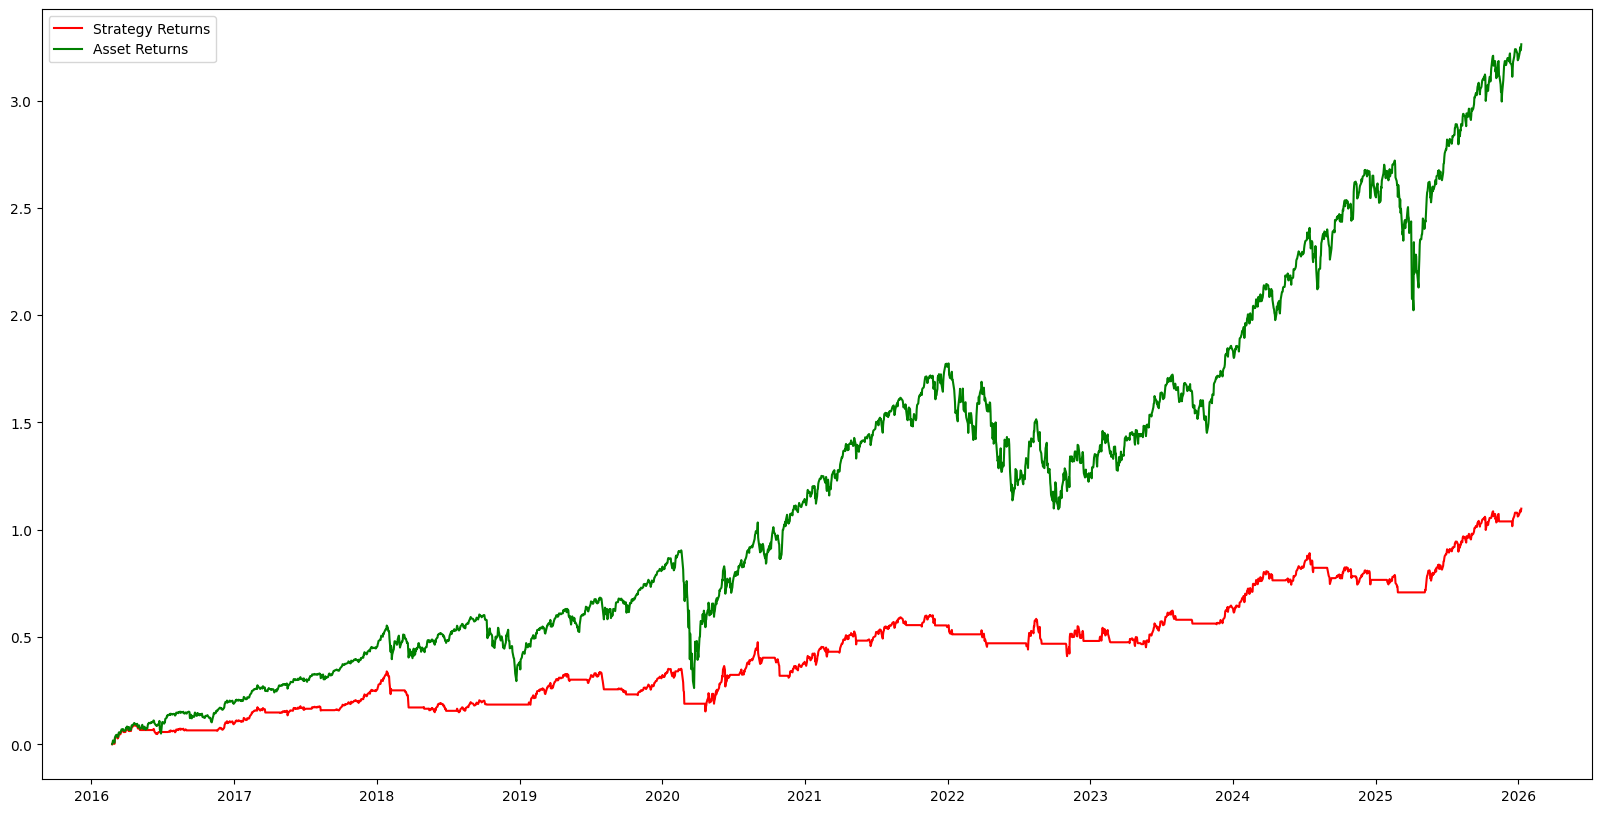

In [7]:

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

Again this strategy doesn't seem to produce very good returns. However, I haven't tested with any other lengths. To find the best lengths for this particular chart I am going to iterate through each possible combination of SMA lengths and log which creates the largest returns.

In [8]:
lengths = []
for fast in range (0, 100+1):
    for mid in range (0 + fast, 100+1):
        for slow in range (0 + mid, 100+1):
            lengths.append((fast, mid, slow))

In [9]:
results = []
print(f"{len(lengths)} combinations to try.")
for i in range(len(lengths)):
    length = lengths[i]
    fast = length[0]
    mid = length[1]
    slow = length[2]

    curr_data = create_strat_data(yf_ticker_data, fast, mid, slow)
    returns = curr_data.iloc[-1]['Strategy_Returns']
    results.append([fast, mid, slow, returns])  
    
    if i == 0:
        print("Starting...")
    elif i % int(len(lengths)/20) == 0: 
        print(f"{int(i / len(lengths) * 100) + 1}% | {i}/{len(lengths)}")

 

176851 combinations to try.
Starting...
5% | 8842/176851
10% | 17684/176851
15% | 26526/176851
20% | 35368/176851
25% | 44210/176851
30% | 53052/176851
35% | 61894/176851
40% | 70736/176851
45% | 79578/176851
50% | 88420/176851
55% | 97262/176851
60% | 106104/176851
65% | 114946/176851
70% | 123788/176851
75% | 132630/176851
80% | 141472/176851
85% | 150314/176851
90% | 159156/176851
95% | 167998/176851
100% | 176840/176851


In [16]:
results_df = pd.DataFrame(results, columns=["Fast", "Mid", "Slow", "Return"])
best_lengths = results_df.sort_values(by=["Return"], ascending=False).iloc[0]
best_lengths

Fast      27.000000
Mid       53.000000
Slow      56.000000
Return     2.131303
Name: 108153, dtype: float64

Here we can see 3, 7 and 14 wouldv'e produced the best returns in the past.

In [11]:
fast = int(best_lengths["Fast"])
mid = int(best_lengths["Mid"])
slow = int(best_lengths["Slow"])

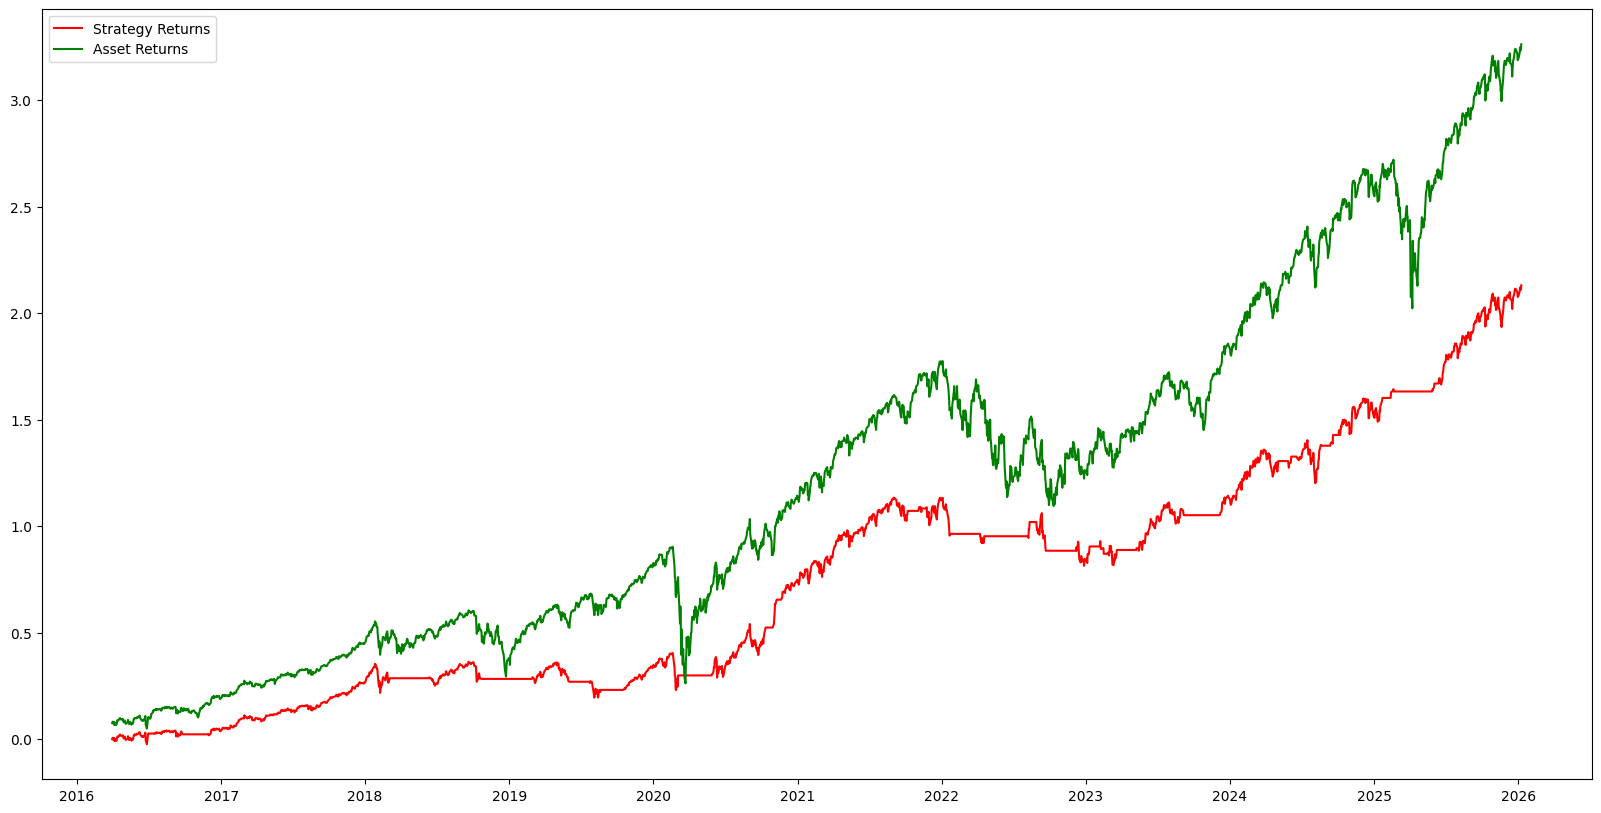

In [12]:
data = create_strat_data(yf_ticker_data, fast, mid, slow)
plot_data = data.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

As we can see with this strategy is positive but still doesn't outperform. However, this is only on long positions so perhaps the same strategy might work on short positions.

As a last little experiement I want to try the same strategy of finding the best SMA lengths but specifically for shorting. Perhaps afterwards we can see if the two strategies work well together.

In [17]:
def create_short_strat_data(yf_data, fast, mid, slow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['FastSMA'] = data['Close'].rolling(window=fast).mean()
    data['MidSMA'] = data['Close'].rolling(window=mid).mean()
    data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

    data['Strategy'] = 0 

    long  = (data['FastSMA'] > data['MidSMA']) & (data['MidSMA'] > data['SlowSMA'])
    short = (data['FastSMA'] < data['MidSMA']) & (data['MidSMA'] < data['SlowSMA'])
    
    data.loc[long,  'Strategy'] = 0
    data.loc[short, 'Strategy'] = -1

    data['Strategy'] = data['Strategy'].shift(1)

    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

In [18]:
short_results = []

for i in range(len(lengths)):
    length = lengths[i]
    fast = length[0]
    mid = length[1]
    slow = length[2]

    curr_data = create_short_strat_data(yf_ticker_data, fast, mid, slow)
    returns = curr_data.iloc[-1]['Strategy_Returns']
    short_results.append([fast, mid, slow, returns])  

    if i == 0:
        print("Starting...")
    elif i % int(len(lengths)/20) == 0: 
        print(f"{int(i / len(lengths) * 100) + 1}% | {i}/{len(lengths)}")


Starting...
5% | 8842/176851
10% | 17684/176851
15% | 26526/176851
20% | 35368/176851
25% | 44210/176851
30% | 53052/176851
35% | 61894/176851
40% | 70736/176851
45% | 79578/176851
50% | 88420/176851
55% | 97262/176851
60% | 106104/176851
65% | 114946/176851
70% | 123788/176851
75% | 132630/176851
80% | 141472/176851
85% | 150314/176851
90% | 159156/176851
95% | 167998/176851
100% | 176840/176851


In [19]:
short_results_df = pd.DataFrame(short_results, columns=["Fast", "Mid", "Slow", "Return"])
short_best_lengths = short_results_df.sort_values(by=["Return"], ascending=False).iloc[0]
short_best_lengths

Fast       7.000000
Mid       11.000000
Slow      97.000000
Return     0.124918
Name: 34427, dtype: float64

In [20]:
fast = int(short_best_lengths["Fast"])
mid = int(short_best_lengths["Mid"])
slow = int(short_best_lengths["Slow"])

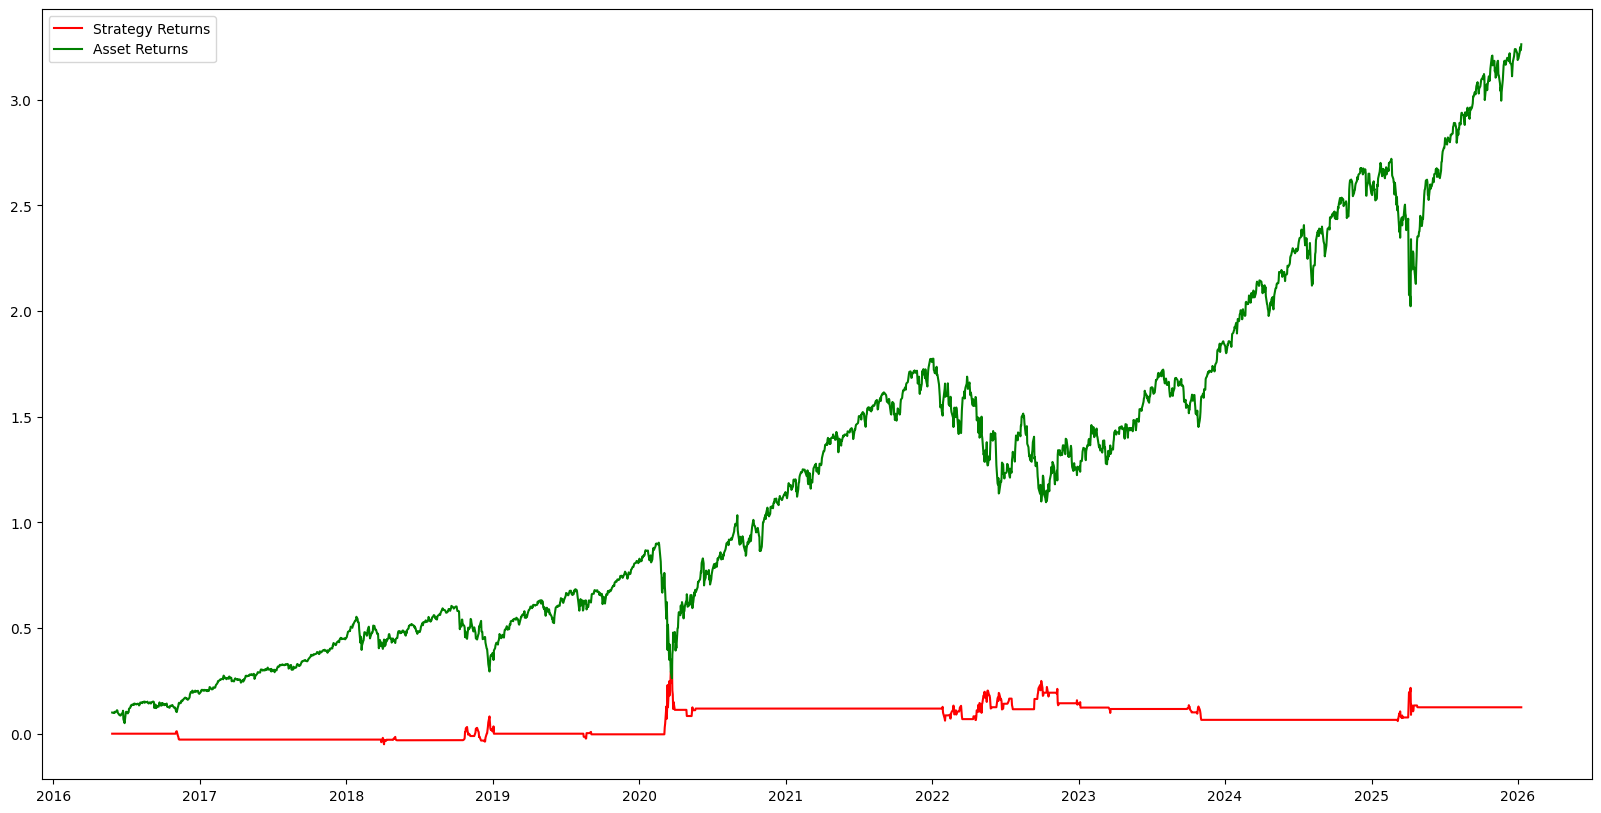

In [21]:
data = create_short_strat_data(yf_ticker_data, fast, mid, slow)
plot_data = data.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

Wasn't expecting anything great as there aren't many downsides in SPY, but this is a positive return.

In [22]:
def create_short_long_strat_data(yf_data, Lfast, Lmid, Lslow , Sfast, Smid, Sslow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['LFastSMA'] = data['Close'].rolling(window=Lfast).mean()
    data['LMidSMA'] = data['Close'].rolling(window=Lmid).mean()
    data['LSlowSMA'] = data['Close'].rolling(window=Lslow).mean()

    data['SFastSMA'] = data['Close'].rolling(window=Sfast).mean()
    data['SMidSMA'] = data['Close'].rolling(window=Smid).mean()
    data['SSlowSMA'] = data['Close'].rolling(window=Sslow).mean()

    data['Strategy'] = 0 

    long  = (data['LFastSMA'] > data['LMidSMA']) & (data['LMidSMA'] > data['LSlowSMA'])
    short = (data['SFastSMA'] < data['SMidSMA']) & (data['SMidSMA'] < data['SSlowSMA'])
    
    data.loc[long,  'Strategy'] = 1
    data.loc[short, 'Strategy'] = -1

    data['Strategy'] = data['Strategy'].shift(1)

    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

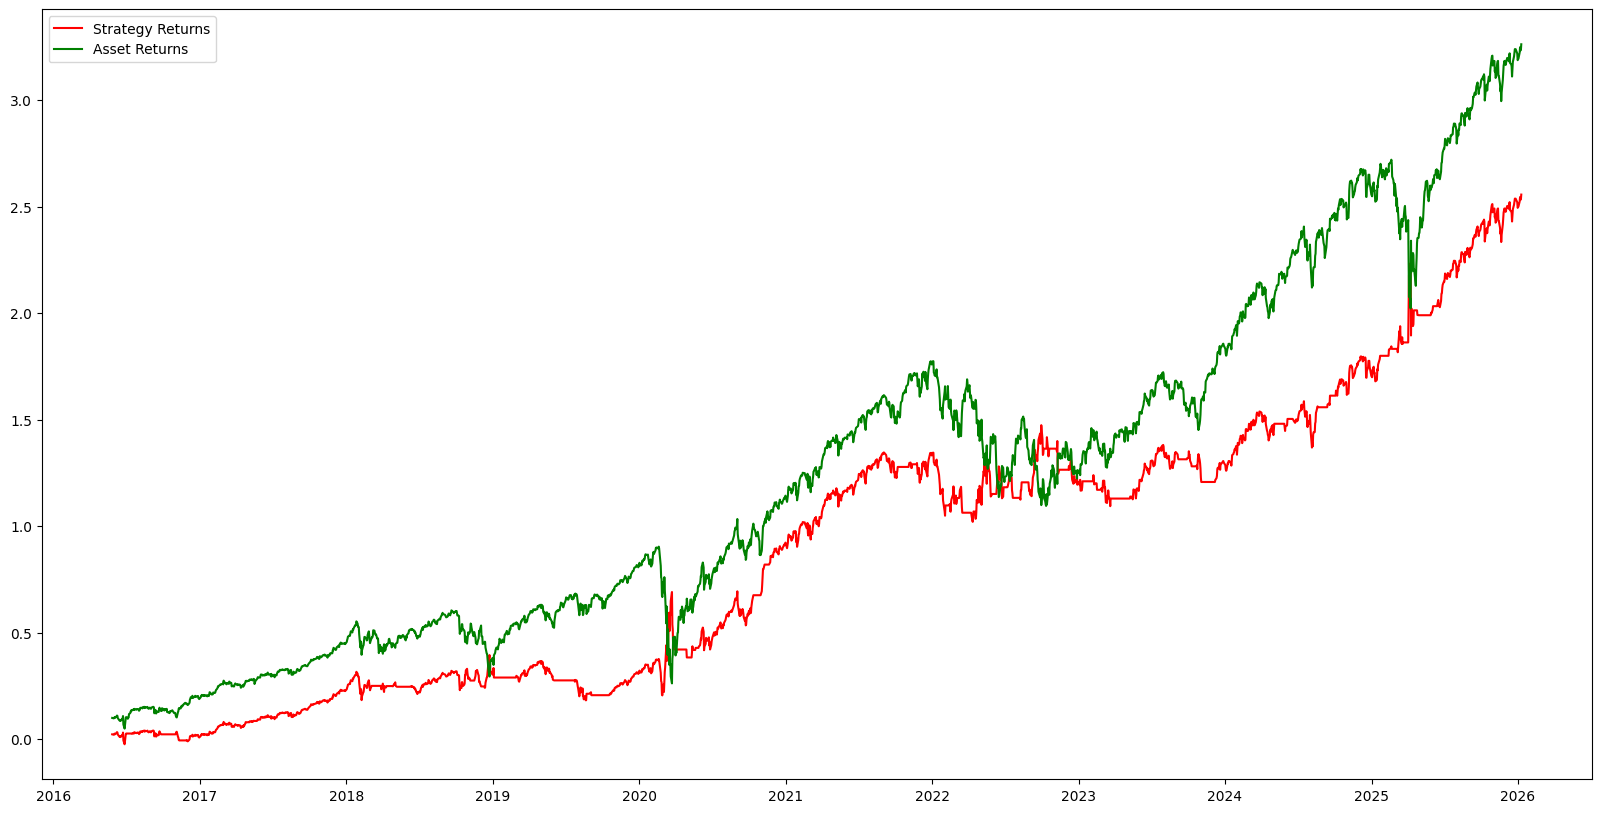

In [24]:
Lfast = int(best_lengths["Fast"])
Lmid = int(best_lengths["Mid"])
Lslow = int(best_lengths["Slow"])

Sfast = int(short_best_lengths["Fast"])
Smid = int(short_best_lengths["Mid"])
Sslow = int(short_best_lengths["Slow"])

data = create_short_long_strat_data(yf_ticker_data, Lfast, Lmid, Lslow, Sfast, Smid, Sslow)
plot_data = data.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

Not so bad. Obviously this is an overfit as we've optimised for this specific ticker, but I think it shows there is potential in the strategy. Perhaps next I will create a way to test and validate in a more accurate way as to account for transactional costs and slippage.